# Exploratory Data Analysis (EDA)

This notebook includes advanced techniques beyond basic plots:
- Target distribution & imbalance
- Seasonality and geographic variation
- Feature distributions & outliers
- Correlation & multicollinearity (VIF)
- Univariate statistical tests
- Interaction effects
- Feature importance (Random Forest)
- Time series analysis
- Dimensionality reduction (PCA)
- Clustering (KMeans)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import chi2_contingency, ttest_ind

# Configure Seaborn style
sns.set_theme(style="whitegrid")

In [2]:
clean_path = Path("clean_weather.csv")
if not clean_path.exists():
    raise FileNotFoundError("Run Step 3 first to create 'clean_weather.csv'.")

df = pd.read_csv(clean_path, parse_dates=["Date"])
print(df.shape)
df.head(3)

(142193, 30)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,Rainfall_lag1,Humidity3pm_lag1,Humidity9am_lag1,Temp3pm_lag1,Temp9am_lag1,Pressure3pm_lag1,Pressure9am_lag1
0,2008-07-01,Adelaide,8.8,15.7,5.0,1.6,2.6,NW,48.0,SW,...,14.9,Yes,0,0.0,52.0,70.0,21.1,16.7,1015.2,1017.6
1,2008-07-02,Adelaide,12.7,15.8,0.8,1.4,7.8,SW,35.0,SSW,...,15.5,No,0,5.0,67.0,92.0,14.9,13.5,1017.7,1017.4
2,2008-07-03,Adelaide,6.2,15.1,0.0,1.8,2.1,W,20.0,NNE,...,13.9,No,0,0.8,52.0,75.0,15.5,13.7,1022.6,1022.4


**Target Variable Distribution**

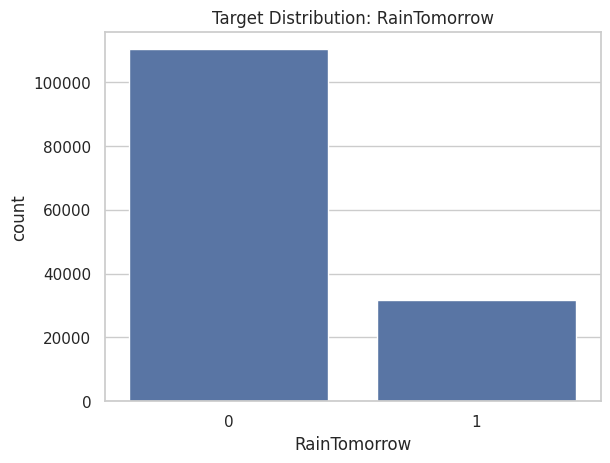

RainTomorrow=1 ratio: 22.42%


In [3]:
sns.countplot(x="RainTomorrow", data=df)
plt.title("Target Distribution: RainTomorrow")
plt.show()

rain_rate = df["RainTomorrow"].mean()
print(f"RainTomorrow=1 ratio: {rain_rate:.2%}")

**Seasonality Trends**

In [4]:
df["Month"] = df["Date"].dt.month
seasonal = df.groupby("Month")["RainTomorrow"].mean().reset_index()

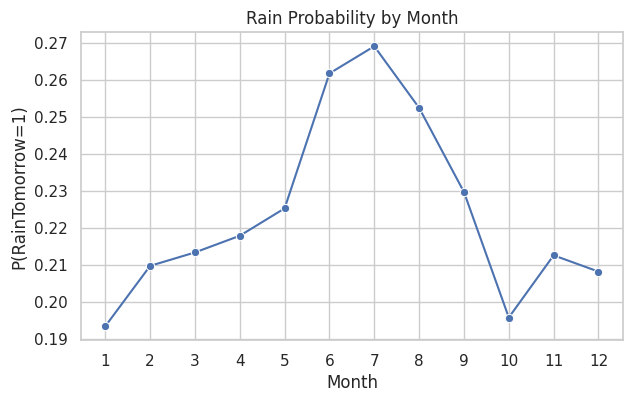

In [5]:
plt.figure(figsize=(7,4))
sns.lineplot(x="Month", y="RainTomorrow", data=seasonal, marker="o")
plt.title("Rain Probability by Month")
plt.xticks(range(1,13))
plt.ylabel("P(RainTomorrow=1)")
plt.show()

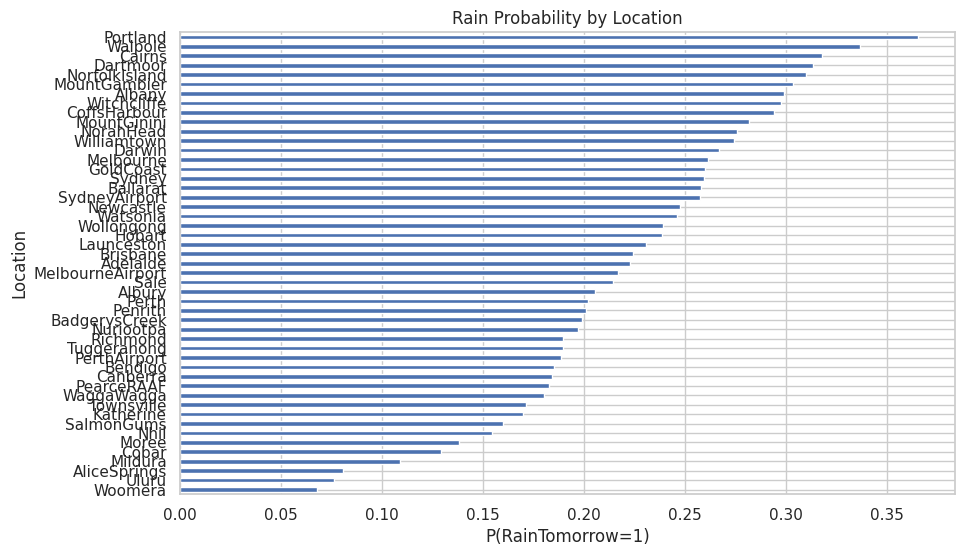

In [6]:
# Geographic variation
if "Location" in df.columns:
    loc_stats = df.groupby("Location")["RainTomorrow"].mean().sort_values()
    plt.figure(figsize=(10,6))
    loc_stats.plot(kind="barh")
    plt.title("Rain Probability by Location")
    plt.xlabel("P(RainTomorrow=1)")
    plt.show()

**Feature Distributions & Outliers**

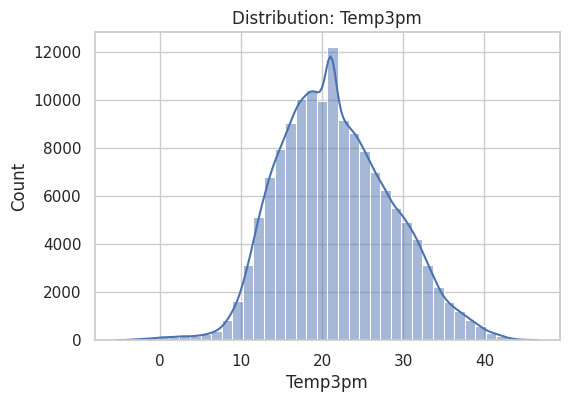

In [7]:
plt.figure(figsize=(6,4))
sns.histplot(df["Temp3pm"], kde=True, bins=40)
plt.title("Distribution: Temp3pm")
plt.show()

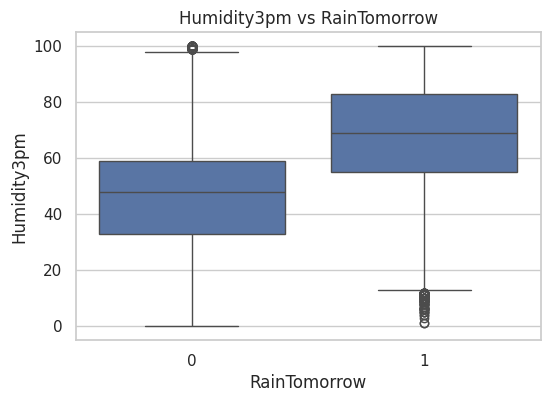

In [8]:
plt.figure(figsize=(6,4))
sns.boxplot(x="RainTomorrow", y="Humidity3pm", data=df)
plt.title("Humidity3pm vs RainTomorrow")
plt.show()

**Correlation Heatmap**

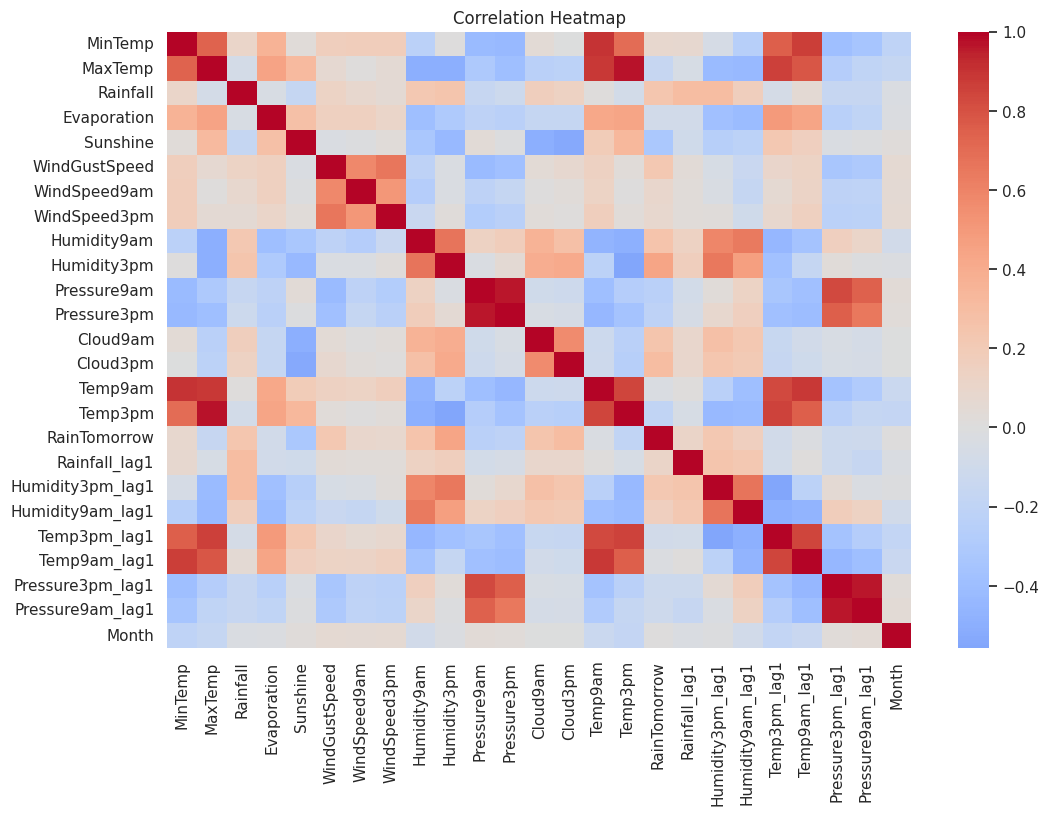

In [9]:
num_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12,8))
sns.heatmap(num_df.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

**Statistical Tests**

In [10]:
# Chi-square: WindDir3pm vs RainTomorrow
if "WindDir3pm" in df.columns:
    contingency = pd.crosstab(df["WindDir3pm"], df["RainTomorrow"])
    chi2, p, dof, exp = chi2_contingency(contingency)
    print("Chi-square WindDir3pm vs RainTomorrow p-value:", p)

Chi-square WindDir3pm vs RainTomorrow p-value: 4.3007467747389834e-250


In [11]:
# T-test: Humidity3pm across classes
rain_yes = df.loc[df["RainTomorrow"]==1, "Humidity3pm"]
rain_no  = df.loc[df["RainTomorrow"]==0, "Humidity3pm"]
tstat, pval = ttest_ind(rain_yes, rain_no, equal_var=False)
print("T-test Humidity3pm p-value:", pval)

T-test Humidity3pm p-value: 0.0


**Interaction Effects**

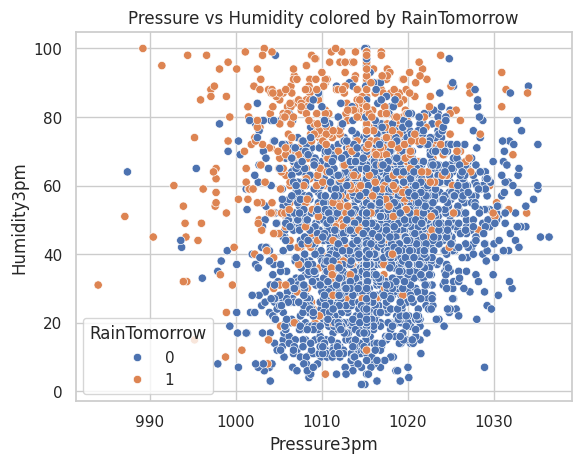

In [12]:
sns.scatterplot(x="Pressure3pm", y="Humidity3pm", hue="RainTomorrow",
                data=df.sample(3000, random_state=42))
plt.title("Pressure vs Humidity colored by RainTomorrow")
plt.show()

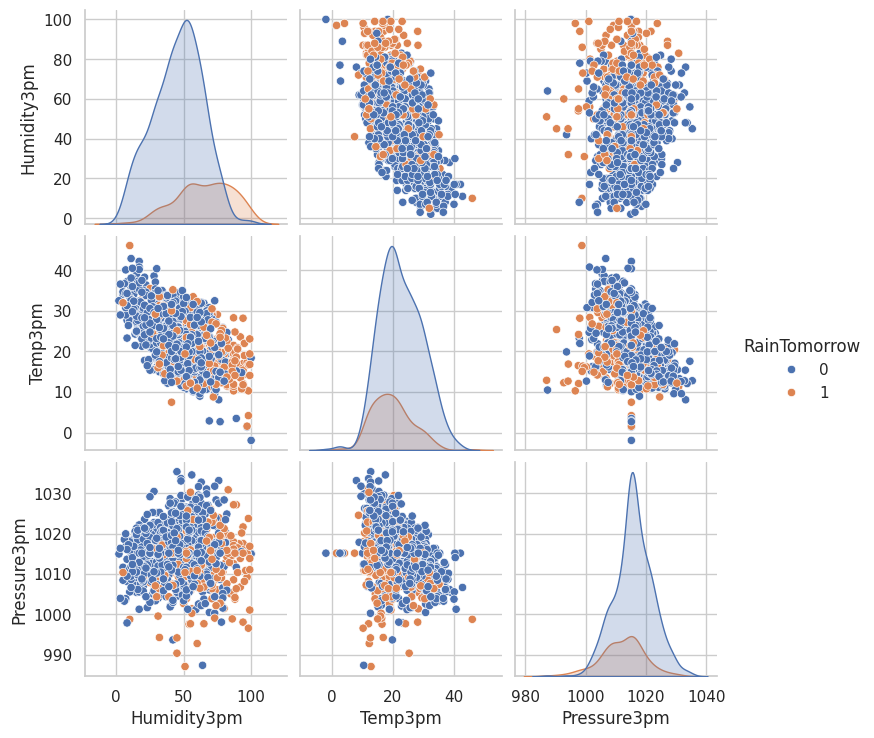

In [13]:
sns.pairplot(df.sample(1000, random_state=42),
             vars=["Humidity3pm","Temp3pm","Pressure3pm"],
             hue="RainTomorrow", diag_kind="kde")
plt.show()

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor

**Feature Importance**

<Axes: title={'center': 'Top Features (Fast RF)'}>

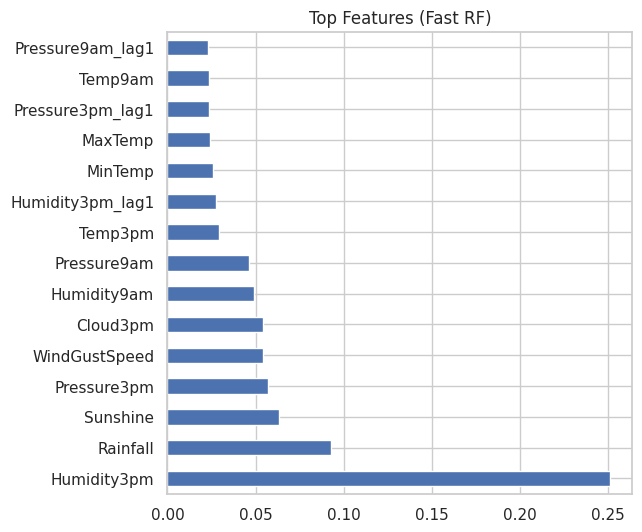

In [25]:
N = min(50_000, len(df))  # cap rows
df_s = df.sample(N, random_state=42)

X = df_s.drop(columns=["RainTomorrow"]).select_dtypes(include=[np.number]).fillna(0)
y = df_s["RainTomorrow"].astype(int)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=100,    # fewer trees
    max_depth=12,        # shallower
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)
rf.fit(X, y)

importances = (
    pd.Series(rf.feature_importances_, index=X.columns)
      .sort_values(ascending=False)
      .head(15)
)
importances.plot(kind="barh", figsize=(6,6), title="Top Features (Fast RF)")

**Time Series (RainTomorrow)**

/tmp/ipython-input-2170634033.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prob = df.set_index("Date").resample("M")["RainTomorrow"].mean()


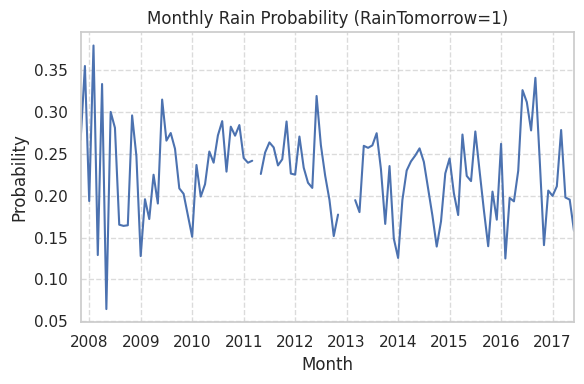

/tmp/ipython-input-2170634033.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_count = df.set_index("Date").resample("M")["RainTomorrow"].sum()


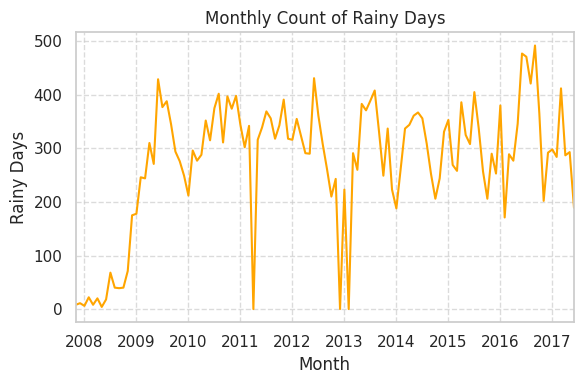

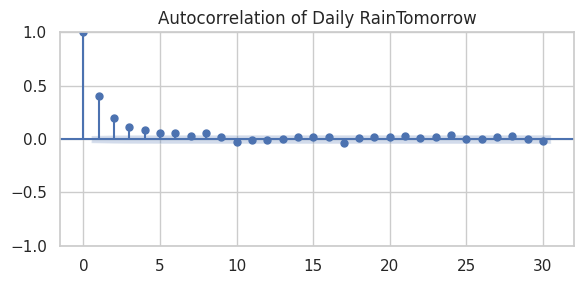

In [20]:
if "Date" in df.columns:
    # Monthly probability of rain (mean of 0/1 target)
    monthly_prob = df.set_index("Date").resample("M")["RainTomorrow"].mean()

    plt.figure(figsize=(6, 4))
    monthly_prob.plot()
    plt.title("Monthly Rain Probability (RainTomorrow=1)")
    plt.ylabel("Probability")
    plt.xlabel("Month")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Monthly count of rainy days (sum of 1’s)
    monthly_count = df.set_index("Date").resample("M")["RainTomorrow"].sum()

    plt.figure(figsize=(6, 4))
    monthly_count.plot(color="orange")
    plt.title("Monthly Count of Rainy Days")
    plt.ylabel("Rainy Days")
    plt.xlabel("Month")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Autocorrelation on daily average
    from statsmodels.graphics.tsaplots import plot_acf
    series = df.set_index("Date")["RainTomorrow"].resample("D").mean().dropna()

    plt.figure(figsize=(6, 3))
    plot_acf(series, lags=30, ax=plt.gca())
    plt.title("Autocorrelation of Daily RainTomorrow")
    plt.tight_layout()
    plt.show()

**PCA Visualization**

In [21]:
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca_comp = pca.fit_transform(X_scaled)

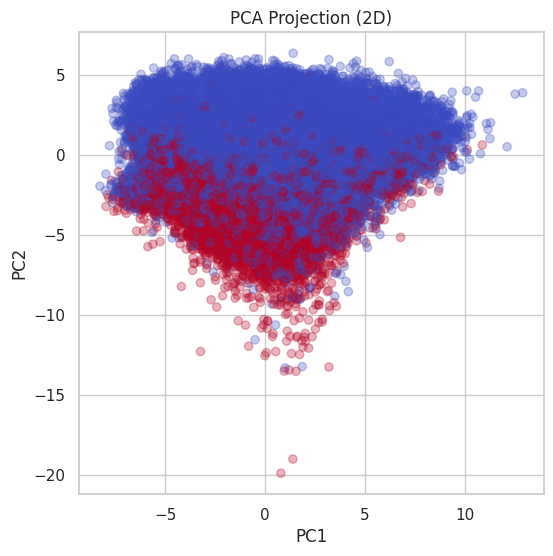

In [22]:
plt.figure(figsize=(6,6))
plt.scatter(pca_comp[:,0], pca_comp[:,1], c=y, cmap="coolwarm", alpha=0.3)
plt.title("PCA Projection (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

**Clustering (KMeans)**

In [23]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

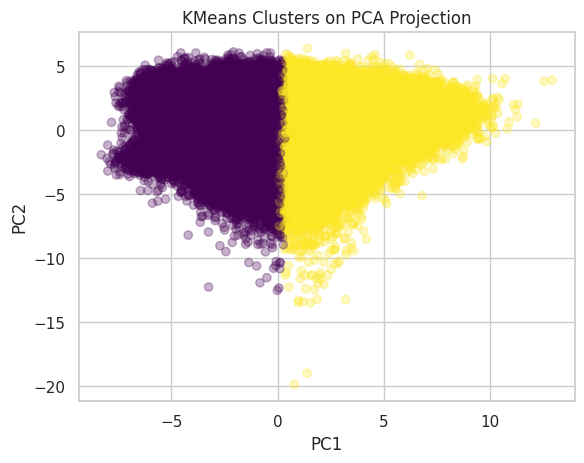

In [24]:
plt.scatter(pca_comp[:,0], pca_comp[:,1], c=clusters, cmap="viridis", alpha=0.3)
plt.title("KMeans Clusters on PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()